## Описание проекта

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов.  
В нём можно быстро узнать рыночную стоимость своего автомобиля.  
В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.  
Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import time

# 1. Подготовка данных

**Загрузите и подготовьте данные.**

В процессе подготовки преобразуем типы некоторых признаков, удалим не нужные признаки, преобразуем категориальные и добавим срок эксплуатации машины (т.е. срок от момента регистрации до момента создания анкеты).

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
aa = df.dtypes.to_frame('dtypes')
aa = aa.join(df.count().to_frame('counts non-null'))
aa = aa.join(df.isna().sum().to_frame('counts is-null'))
bb = pd.Series([len(df[col].unique()) for col in aa.index], index=aa.index)
aa = aa.join(bb.to_frame('counts unique'))
counts = df._data.get_dtype_counts()
dtypes = ["{k}({kk:d})".format(k=k[0], kk=k[1]) for k in sorted(counts.items())]
print("dtypes: {types}".format(types=", ".join(dtypes)))

aa

dtypes: int64(7), object(9)


,dtypes,counts non-null,counts is-null,counts unique
DateCrawled,object,354369,0,271174
Price,int64,354369,0,3731
VehicleType,object,316879,37490,9
RegistrationYear,int64,354369,0,151
Gearbox,object,334536,19833,3
Power,int64,354369,0,712
Model,object,334664,19705,251
Kilometer,int64,354369,0,13
RegistrationMonth,int64,354369,0,13
FuelType,object,321474,32895,8


- Очевидно, что 3 признака имеют тип timestamp - необходимо преобразовать;  
- Пять признаков имеют тип object и являются категориальными. И только в этих признаках существуют пропуски;  
- Также к категориальным признакам можно отнести признак 'Kilometer' из-за малого числа значений, а признак 'NumberOfPictures' можно вообще удалить.


In [5]:
# преобразование типа даты

date_columns = ['DateCrawled', 'DateCreated', 'LastSeen']
for col in date_columns:
    df[col] = pd.to_datetime(df[col])

In [6]:
# категориальные признаки
cat_columns = [col for col in df.columns if df[col].dtypes.name == 'object']
cat_columns

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [7]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Поскольку во всех записях количество фотографий нулевое, то это поле не нужно. Удалим его.

In [8]:
df.drop('NumberOfPictures', axis=1, inplace=True)

In [9]:
df[date_columns].describe()

,DateCrawled,DateCreated,LastSeen
count,354369,354369,354369
unique,271174,109,179150
top,2016-03-24 14:49:47,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,13719,17
first,2016-03-05 14:06:22,2014-03-10 00:00:00,2016-03-05 14:15:08
last,2016-04-07 14:36:58,2016-04-07 00:00:00,2016-04-07 14:58:51


На мой взгляд, дата скачивания анкеты никакой роли не играет, поэтому его смело можно удалить.  
Последние две даты важны, но не сами по себе, а как:  
- срок от регистрации автомобиля до даты создания анкеты; 
- срок от создания анкеты до последнего просмотра.

Поэтому создадим соответствующие 2 поля: 'LifePeriod' и 'LastSeenPeriod', а поля дат удалим.

In [10]:
# LifePeriod в месяцах
delta_years = (df['DateCreated'].dt.year - df['RegistrationYear']) * 12 
delta_months = (df['DateCreated'].dt.month - df['RegistrationMonth'])
df['LifePeriod'] = delta_years + delta_months
df['LifePeriod'] = df['LifePeriod'].astype('int')

# LastSeenPeriod в днях
df['LastSeenPeriod'] = ((df['LastSeen'] - df['DateCreated']).dt.total_seconds() // (3600 * 24)).astype('int')

# Удаляем признаки DateCrawled, DateCreated и LastSeen
df.drop(date_columns, axis=1, inplace=True)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,LifePeriod,LastSeenPeriod
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,70435,279,14
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,66954,58,14
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,90480,139,22
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074,177,0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437,92,6


In [11]:
df[cat_columns].describe()

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
count,316879,334536,334664,321474,354369,283215
unique,8,2,250,7,40,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,91457,268251,29232,216352,77013,247161


В некоторых категориальных признаках существует несколько десятков, а то и сотен значений и прямое кодирование (One-Hot Encoding) добавит несколько сотен новых столбцов!  
Поэтому в нашем случае подошло бы порядковое кодирование (OrdinalEncoder), но оно требует, чтобы не было пропусков.  

Поскольку пропуски только в категориальных признаках, то мы не будем удалять записи с пропусками, а заполним их значением 'nan' и будем использовать как одно из значений этого признака, что позволить применить технику OrdinalEncoder.

In [12]:
df.fillna('nan', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 14 columns):
Price                354369 non-null int64
VehicleType          354369 non-null object
RegistrationYear     354369 non-null int64
Gearbox              354369 non-null object
Power                354369 non-null int64
Model                354369 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             354369 non-null object
Brand                354369 non-null object
NotRepaired          354369 non-null object
PostalCode           354369 non-null int64
LifePeriod           354369 non-null int64
LastSeenPeriod       354369 non-null int64
dtypes: int64(8), object(6)
memory usage: 37.9+ MB


In [13]:
#sns.pairplot(df, hue='Price');

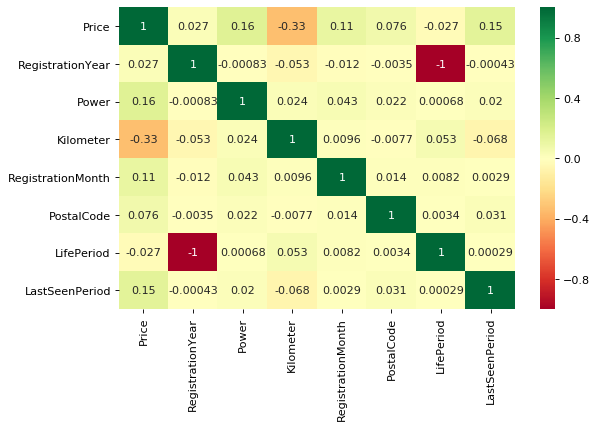

In [14]:
# матрица корреляций

plt.figure(figsize=(8,5), dpi= 80)
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)
plt.show()

Прекрасно видно, что год регистрации и продолжительность эксплуатации сильно обратно зависимы. Оно и понятно, чем больше год регистрации, тем меньше срок эксплуатации автомобиля до создания анкеты. 

### Проанализируем целевой признак. 


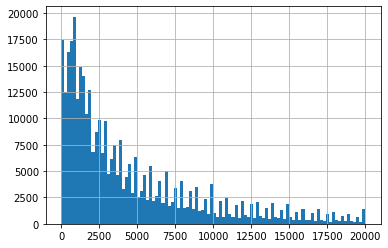

In [15]:
# распределение целевого признака
df['Price'].hist(bins=100);

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64


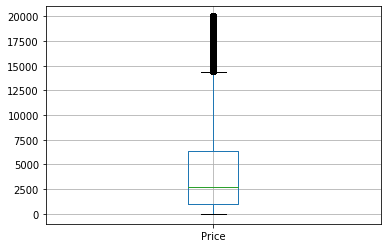

In [16]:
print(df['Price'].describe())

df.boxplot(column='Price');

In [17]:
df[df['Price'] == 0]['Price'].count()

10772

Обнаружено 10772 записей, в которых значение целевого признака равно нулю. Считаю, что атомобиль не может продаваться за нулевую цену и такие случаи необходимо исключить.  

Что касается большого разброса, то цена зависит от модели автомобиля и его характеристик. В данном случае, это не является выбросами.

In [18]:
df = df[df['Price'] > 0]
df.shape

(343597, 14)

# 2. Обучение моделей

Для моделей будем применять LGBMRegressor из библиотеки LightGBM.  

Попробуем применить две разные кодировки из наших курсов - OrdinalEncoder и OneHotEncoder (pd.get_dummies).  

Поскольку заказчику важны:  
- качество предсказания;  
- скорость предсказания;  
- время обучения.  

То подготовим функцию, возвращающую метрику RMSE, время обучения и время предсказания.

In [19]:
def run_model(x, y, x_valid, y_valid, params=None):
    if params is None:
        model = lgb.LGBMRegressor(random_state=123456)
    else:
        model = lgb.LGBMRegressor(
                random_state=123456,
                n_estimators = params['num_est'],
                max_depth = params['max_dpth'],
                num_leaves = params['num_lvs'],
                learning_rate = params['lrn_rate'],
                objective='regression',
                nthread=-1
            )
    start_time = time.time()

    model.fit(x, y)
    fit_time = time.time()

    y_predict = model.predict(x_valid)
    predict_time = time.time()

    rmse = mean_squared_error(y_valid, y_predict) ** 0.5
    rmse_train = mean_squared_error(y, model.predict(x)) ** 0.5
    return fit_time - start_time, predict_time - fit_time, rmse, rmse_train

**OrdinalEncoder**

In [20]:
%%time
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(df), columns=df.columns)
data_ordinal.head()

CPU times: user 1.1 s, sys: 40 ms, total: 1.14 s
Wall time: 1.15 s


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,LifePeriod,LastSeenPeriod
0,255.0,3.0,80.0,1.0,0.0,116.0,12.0,0.0,7.0,38.0,0.0,4896.0,366.0,14.0
1,3586.0,2.0,98.0,1.0,190.0,159.0,11.0,5.0,2.0,1.0,2.0,4613.0,145.0,14.0
2,2589.0,7.0,91.0,0.0,163.0,117.0,11.0,8.0,2.0,14.0,0.0,6989.0,226.0,22.0
3,695.0,6.0,88.0,1.0,75.0,116.0,12.0,6.0,7.0,38.0,1.0,7029.0,264.0,0.0
4,1332.0,6.0,95.0,1.0,69.0,101.0,9.0,7.0,2.0,31.0,1.0,4210.0,179.0,6.0


In [21]:
y = data_ordinal['Price']
x = data_ordinal.drop(['Price'], axis=1)

x, x_test, y, y_test = train_test_split(x, y, test_size=0.20, random_state=123456)
x, x_valid, y, y_valid = train_test_split(x, y, test_size=0.25, random_state=123456)

x.shape, y.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

((206157, 13), (206157,), (68720, 13), (68720,), (68720, 13), (68720,))

In [22]:
%%time

# модель со стандартными параметрами
fit_time, pred_time, rmse, _ = run_model(x, y, x_valid, y_valid)
print('RMSE:{},\n время обучения: {: .2f}сек.,\n время предсказания: {: .2f}сек.'.format(rmse, fit_time, pred_time))
print()

RMSE:362.28568024801956,
 время обучения:  8.83сек.,
 время предсказания:  0.81сек.

CPU times: user 12 s, sys: 88 ms, total: 12.1 s
Wall time: 12.1 s


**OHE**

In [23]:
df.shape

(343597, 14)

In [24]:
%%time
data_ohe = pd.get_dummies(df, drop_first=True, columns=cat_columns)
data_ohe.shape

CPU times: user 1.18 s, sys: 76 ms, total: 1.26 s
Wall time: 1.29 s


(343597, 316)

In [25]:
data_ohe.head()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode,LifePeriod,LastSeenPeriod,VehicleType_convertible,VehicleType_coupe,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_no,NotRepaired_yes
0,480,1993,0,150000,0,70435,279,14,0,0,...,0,0,0,0,0,0,1,0,0,0
1,18300,2011,190,125000,5,66954,58,14,0,1,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,8,90480,139,22,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1500,2001,75,150000,6,91074,177,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,3600,2008,69,90000,7,60437,92,6,0,0,...,0,0,0,0,0,0,0,0,1,0


In [26]:
y_ohe = data_ohe['Price']
x_ohe = data_ohe.drop(['Price'], axis=1)

x_ohe, x_ohe_test, y_ohe, y_ohe_test = train_test_split(x_ohe, y_ohe, test_size=0.20, random_state=123456)
x_ohe, x_ohe_valid, y_ohe, y_ohe_valid = train_test_split(x_ohe, y_ohe, test_size=0.25, random_state=123456)

x_ohe.shape, y_ohe.shape, x_ohe_valid.shape, y_ohe_valid.shape, x_ohe_test.shape, y_ohe_test.shape

((206157, 315), (206157,), (68720, 315), (68720,), (68720, 315), (68720,))

In [27]:
%%time

# модель со стандартными параметрами
fit_time, pred_time, rmse, _ = run_model(x_ohe, y_ohe, x_ohe_valid, y_ohe_valid)
print('RMSE:{},\n время обучения: {: .2f}сек.,\n время предсказания: {: .2f}сек.'.format(rmse, fit_time, pred_time))
print()

RMSE:1744.0730440584653,
 время обучения:  10.03сек.,
 время предсказания:  1.21сек.

CPU times: user 14 s, sys: 712 ms, total: 14.7 s
Wall time: 14.8 s


Как видно из результатов, кодировка техникой OHE создала дополнительно 312 признаков. Соотвественно, эта кодировка занимает значительно больше времени, чем с кодировкой техникой OrdinalEncode. Также, как и время обучения модели и предсказания результатов.  

Значение метрики RMSE для данных с кодировкой OHE почти в 5 раз больше, чем для данных с OrdinalEncoder. Это опять же из-за добавления кучи дополнительных признаков.  
А вот достаточно ли хороши полученные значения RMSE для стандартной модели рассмотрим далее.

# 3. Анализ моделей

### Настройка гиперпараметров модели

In [28]:
%%time
modeles = []
for num_est in (100,1000, 4000):
    for max_dpth in (3,4,10):
        for num_lvs in (25,35):
            for lrn_rate in (0.05, 0.1, 0.2):
                params = {
                    'num_est': num_est, 
                    'max_dpth': max_dpth,
                    'num_lvs': num_lvs,
                    'lrn_rate': lrn_rate,
                    'reg_alph': 0,
                    'reg_lmbd': 0
                }
                fit_time, pred_time, rmse, rmse_train = run_model(x, y, x_valid, y_valid, params)
                modeles.append([num_est, max_dpth, num_lvs, lrn_rate, fit_time, pred_time, rmse, rmse_train])


CPU times: user 1h 56min 5s, sys: 17.2 s, total: 1h 56min 22s
Wall time: 1h 57min 6s


In [43]:
modeles = pd.DataFrame(modeles, columns = ['num_est', 'max_dpth', 'num_lvs', 'lrn_rate', 
                                           'fit_time', 'pred_time', 'rmse', 'rmse_train'])
# modeles.to_csv('modeles2.csv')
modeles['labels'] = modeles.apply(lambda row: '{}_{}_{}_{}'.format(int(row['num_est']), 
                                                                   int(row['max_dpth']), 
                                                                   int(row['num_lvs']), 
                                                                   row['lrn_rate']), axis=1)
modeles.tail()

,num_est,max_dpth,num_lvs,lrn_rate,fit_time,pred_time,rmse,rmse_train,labels
49,4000,10,25,0.10,226.818172,28.373539,327.617902,239.622018,4000_10_25_0.1
50,4000,10,25,0.20,192.383200,27.000138,330.851584,201.642195,4000_10_25_0.2
51,4000,10,35,0.05,206.191214,33.424220,328.409159,255.864275,4000_10_35_0.05
52,4000,10,35,0.10,189.979159,31.844275,327.079181,220.094166,4000_10_35_0.1
53,4000,10,35,0.20,186.575516,30.523115,330.686015,177.673118,4000_10_35_0.2


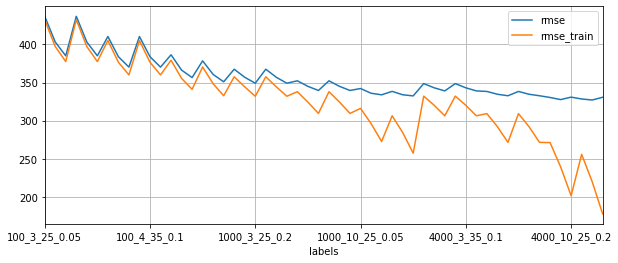

In [45]:
modeles.plot(x='labels', y=['rmse', 'rmse_train'], grid=True, figsize=(10, 4));


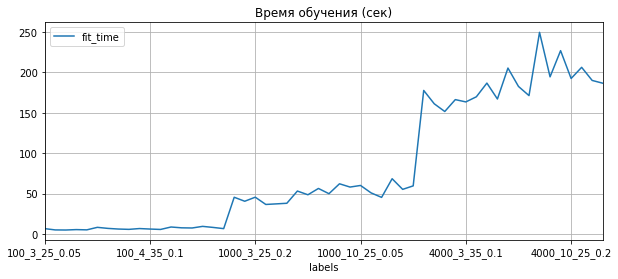

In [47]:
modeles.plot(x='labels', y='fit_time', grid=True, figsize=(10, 4), title='Время обучения (сек)');

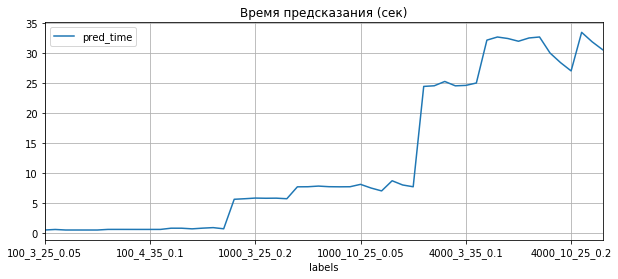

In [48]:
modeles.plot(x='labels', y='pred_time', grid=True, figsize=(10, 4), title='Время предсказания (сек)');

Как видно из диаграмм, время обучения и предсказания скачкообразно увеличивается для n_estimators=1000, а затем при n_estimators=4000.  

Самые минимальные значения RMSE оказались при n_estimators=4000, но они не сильно отличаются от минимальных значениях RMSE при n_estimators=1000, но при этом время обучения и предсказания увеличиваются в 4 раза и более.  

**Поскольку для заказчика важны скорости обучения и предсказания модели, то предлагается оптимальной моделью считать модель с n_estimators=1000 и минимальным RMSE.** 

In [53]:
modeles_1000 = modeles[modeles['num_est'] == 1000]
min_rmse = modeles_1000[modeles_1000['rmse'] == modeles_1000['rmse'].min()].reset_index(drop=True)
min_rmse

,num_est,max_dpth,num_lvs,lrn_rate,fit_time,pred_time,rmse,rmse_train,labels
0,1000,10,35,0.2,59.582502,7.703663,332.449922,257.356482,1000_10_35_0.2


In [54]:
# параметры наилучшей модели

params_best_model = {
    'num_est': min_rmse.loc[0, 'num_est'], 
    'max_dpth': min_rmse.loc[0, 'max_dpth'],
    'num_lvs': min_rmse.loc[0, 'num_lvs'],
    'lrn_rate': min_rmse.loc[0, 'lrn_rate']
}
params_best_model

{'num_est': 1000, 'max_dpth': 10, 'num_lvs': 35, 'lrn_rate': 0.2}

In [56]:
%%time

fit_time, pred_time, rmse, _ = run_model(x, y, x_valid, y_valid, params_best_model)
print('RMSE:{},\n время обучения: {: .2f}сек.,\n время предсказания: {: .2f}сек.'.format(rmse, fit_time, pred_time))
print()

RMSE:332.4499222099822,
 время обучения:  65.78сек.,
 время предсказания:  7.31сек.

CPU times: user 1min 33s, sys: 444 ms, total: 1min 34s
Wall time: 1min 34s


- Видим заметное улучшение качества прогнозирования за счет подбора оптимальных гиперпараметров модели по сравнению с дeфолтной моделью lightgbm (RMSE:362.28568024801956)

**OHE**

Ранее мы уже решили, что кодирование техникой OHE приводит к значительному повышению времени обучения, по сравнению с техникой OrdinalEncode и мы ее исключим.  
Здесь мы просто просчитаем модель с лучшими параметрами, которые определили в предыдущем пункте, чтобы еще раз убедиться в нашем выводе.

In [57]:
%%time
# модель с лучшими параметрами для OrdinalEncoder
fit_time, pred_time, rmse, _ = run_model(x_ohe, y_ohe, x_ohe_valid, y_ohe_valid, params_best_model)
print('RMSE:{},\n время обучения: {: .2f}сек.,\n время предсказания: {: .2f}сек.'.format(rmse, fit_time, pred_time))
print()


RMSE:1600.1580771712538,
 время обучения:  153.06сек.,
 время предсказания:  7.82сек.

CPU times: user 3min, sys: 1.68 s, total: 3min 2s
Wall time: 3min 4s


Мы еще раз убеждаемся, что время обучения модели значительно выше чем, у модели с кодировкой OrdinalEncode, хотя выбранные параметры модели тоже привели к значительному снижению RMSE по сравнению с дефолтной моделью (RMSE:1744.0730440584653).